In [1]:
# NB: per eseguire questo notebook come file Python, scegliere il menù "File -> Download as -> Python (.py)" .
# Da Canopy, scommentando questa istruzione si hanno i grafici nella console e non in finestre aggiuntive:
#get_ipython().magic(u'matplotlib inline')
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle
import numpy.matlib as npmat
from scipy.sparse import *
from scipy.sparse.linalg import *

from matplotlib import animation, rc
rc('animation', html='html5')
from IPython.display import display, Image, HTML

In [2]:
def dati_veri_dominio(corrosione=False):
  if not corrosione:
    Lungh = 5.
    n = 50
  else:
    Lungh = 2. # il dominio effettivo si riduce
    n = 20
  #endif
  Dx = Lungh/n  # passo di discretizzazione nello spazio
  return Lungh,n,Dx

In [3]:
def g0(n, Dx):
  # supponiamo che ci sia temperatura uniforme pari a 20 gradi
  T0 = 20.0 * np.ones(n+1)
  return T0

In [4]:
def f0(t): # forzante di tipo "flash" applicata al nodo 0
  t = t * 5e-04
  W = 6.6296e+006
  sig = 0.010
  Q = (W*t) * np.exp(-np.sqrt(t)/sig)
  return Q

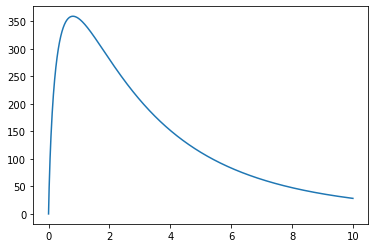

In [5]:
t = np.arange(0.0,10.0,0.01)
plt.figure(1); plt.plot(t,f0(t)); plt.show()

In [6]:
def calore_1d_fd(Lungh,n,Dx,N,eulero):
  # Approssimazione del seguente problema:
  # Dato (t,x) in [t0, tf] x [0,L], con L variabile, sia h il passo temporale
  # di discretizzazione di [t0, tf] e Dx il passo di [0,L].
  # equazione del calore: T=T(t,x) temperatura in [t0, tf] x [0,L]
  # dT/dt - c (d^2)T/d (x^2)=0
  # dT/dx(t,0)=f0(t), forzante(flash) nota
  # dT/dx (t,L)=0, condizioni di Neumnann omogenee
  # T(t0,x)=g0(x), condizioni iniziali note
  # problema discretizzato nello spazio: Ti(t)=T(t,xi), xi=i*Dx;
  # T'(t)=c A T(t)+b(t), T(t)=[T0(t),T1(t),...,Tn(t)]', b(t)=[f0(t), 0,...,0]' ; (ODE)
  # T(t0)=g0 <=> [T0(t0),T1(t0),...,Tn-1(t0)]' = [g0(x0),g0(x1),...,g0(xn-1),g0(xn)]';
  c = 1.
  tfin = 10.
  tin = 0.
  dt = (tfin-tin)/N
  A = lil_matrix((n+1,n+1))
  for i in range(1,n+1): # nodi interni: discretizzazione del laplaciano
    A[i,i] = -2./Dx**2
    if i > 0:      A[i,i-1] = 1./Dx**2   #endif
    if i < n:      A[i,i+1] = 1./Dx**2   #endif
  #endfor
  # devo imporre le CB: quindi aggiungo le equazioni corrispondenti
  A[0,0] = -1./Dx; A[0,1] = 1./Dx
  A[n,n] = -1./Dx; A[n,n-1] = 1./Dx
  # otteniamo quindi l'equazione discretizzata nello spazio:
  # T'(t)=c A T(t)+b(t), T(t)=[T0(t),T1(t),...,Tn(t)]', b(t)=[f0(t), 0,...,0]' ; (ODE)
  # T(t0)=g0 <=> [T0(t0),T1(t0),...,Tn-1(t0)]' = [g0(x0),g0(x1),...,g0(xn-1),g0(xn)]';
  # Osservazione: b(t) puo' essere pensato come l'ingresso del modello (u=b(t))
  # quindi otteniamo il seguente sistema state-space:
  # T'(t)=c A T(t)+b(t);
  # T_vero_x0(t)=T0(t)=C T(t), C=[1,0,...,0]; <=> serie temporale delle temperature raccolte in x0
  # Quindi l'ordine nx del modello state space e' n+1.
  # per risoluzione dell'(ODE) uso un theta metodo
  T_old = np.atleast_2d(g0(n,Dx)).T; # CI (per k=0)
  T_x0 = np.zeros(N+1)
  T_hist = np.zeros((n+1,N+1))
  T_hist[:,[0]] = T_old
  T_x0[0] = T_old[0]
  M1 = np.eye(n+1)-dt*c*A
  print(M1[0:4,0:4])
  if eulero == 0:  # esplicito
    for k in range(N):
      b = np.zeros((n+1,1))
      b[0] = f0(k*dt+tin)
      T = dt * (c*A*T_old+b)+T_old  # T(k+1)=(I+hcA)T(k)+h*b
      T_old = T.copy()
      T_x0[k+1] = T_old[0,0]
    #endfor
  elif eulero == 1:  # implicito
    for k in range(N):
      b = np.zeros((n+1,1))
      b[0] = f0(k*dt+tin)
      T = np.linalg.solve(M1, dt*b+T_old)  # T(k+1)=(I-dt*c*A)^{-1}T(k)+(I-dt*c*A)^{-1}*dt*b
      T_hist[:,[k+1]] = T 
      T_old = T.copy()
      T_x0[k+1] = T_old[0,0]
    #endfor
  #endif
  return T_x0,M1,dt,T_hist

In [7]:
# 1) generazione dei dati sperimentali:
eulero = 1  # 0=esplicito, 1=implicito
fid = open("eulero.pydat","wb")
cPickle.dump(eulero,fid)
fid.close()
#
# I "dati sperimentali" sono in questo caso dei dati prodotti da una
# simulazione con il flash virtuale (quindi e' la risposta al campione
# unitario), piu' del rumore aggiunto, ed un "h" prestabilito: e' da vedere
# se viene correttamente identificato dall'algoritmo di analisi dei dati.
N = 1000; # numero di istanti temporali
Lungh,n,Dx = dati_veri_dominio(corrosione=False)
print("Dx = ", Dx)
fid = open("L_sano.pydat","wb")
cPickle.dump(Lungh,fid)
fid.close()
T,M1vero,dt,T_hist = calore_1d_fd(Lungh,n,Dx,N,eulero)
# aggiunta del rumore per simulare le misure sperimentali
std_err = 1.e-3
rumore = std_err*np.random.randn(N+1)
T_vero_x0 = T + rumore
T_hist_vero = T_hist + std_err*np.random.randn(T_hist.shape[0],N+1)
#
# dati sperimentali del campione corroso:
Lungh,n,Dx = dati_veri_dominio(corrosione=True)
fid = open("L_corroso.pydat","wb")
cPickle.dump(Lungh,fid)
fid.close()
T,_,_,_ = calore_1d_fd(Lungh,n,Dx,N,eulero)
rumore = std_err*np.random.randn(N+1)
T_vero_x0_corr = T + rumore
#save T_vero_x0_corr T_vero_x0_corr;
#disp('dati sperimentali relativi al campione non corroso: T_vero_x0_corr.mat');

Dx =  0.1
[[ 1.1 -0.1  0.   0. ]
 [-1.   3.  -1.   0. ]
 [ 0.  -1.   3.  -1. ]
 [ 0.   0.  -1.   3. ]]
[[ 1.1 -0.1  0.   0. ]
 [-1.   3.  -1.   0. ]
 [ 0.  -1.   3.  -1. ]
 [ 0.   0.  -1.   3. ]]


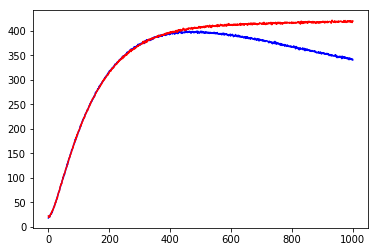

In [8]:
plt.figure(11); plt.plot(T_vero_x0,'b-'); plt.plot(T_vero_x0_corr,'r-'); plt.show()

In [ ]:
# 2) analisi della corrosione sulla base dei dati sperimentali
print('validazione del modello di riferimento e determinazione di Dx:')
fid = open("L_sano.pydat","rb")
Lungh = cPickle.load(fid) # contiene la lunghezza "Lungh" del campione sano
Dx = validazione(T_vero_x0)
fid = open("Dx.pydat","wb")
cPickle.dump(Dx,fid)
fid.close()

In [2]:
def validazione(T_vero_x0)
    Lungh,_,_ = dati_veri_dominio(corrosione=False)
    MDL = [] 
    AIC = [] 
    for n=range(5,80,5):
        Dx = Lungh / n
        T,_,_,_ = calore_1d_fd(Lungh,n,Dx,N,eulero)
        # loss function V(T)
        # d = n+1 number of parameters
        # N is the number of samples
        MDL = MDL.append(...) 
        AIC = AIC.append(...)
    #endfor
    # do the plot of AIC and MDL!
    plt.figure(1); plot(AIC);
    plt.figure(2); plot(MDL); plt.show()
    # compute the index at the minimum of AIC and MDL ...
    n_min
    Dx = Lungh / n_min
    return Dx

SyntaxError: invalid syntax (<ipython-input-2-b03fe1fbbe89>, line 1)

In [ ]:
print('analisi della corrosione - determinazione dell''ordine mediante il PEM:')
n = pem(T_vero_x0_corr)

In [ ]:
def pem()
    # very similar to the exercise of estimating 
    # the parameters in the three masses lab

In [14]:
# stima delle temperature interne con il filtro di Kalman:
A = np.linalg.inv(M1vero)
nx = A.shape[1]
B = np.zeros((nx,1)); B[0,0] = dt; B = np.linalg.inv(M1vero) @ B
C = np.zeros((1,nx)); C[0,0] = 1
var_x = 1.e-6
Q = var_x*np.eye(nx)
var_y = std_err**2
R = 0*var_y*np.eye(1)
if 0:
    x0 = T_hist[:,0] 
else:
    x0 = np.zeros(nx)
#endif
y = np.zeros([1,N])
x = np.atleast_2d(x0.copy()).T
X_hist = np.zeros((x.shape[0],N+1))
X_hist[:,0] = x0.copy()
pe = np.zeros(N+1)
y_hist = np.zeros(N+1)
P = np.diag(np.ones(nx)) # suppongo che l'errore iniziale di stima dello stato sia grande.
for i in range(0,N):
    x = A @ x + B @ np.atleast_2d(f0(i*dt))
    y[:,i] = C @ x;
    P = A @ P @ A.T + Q
    Lambda = C @ P @ C.T + R
    #print "Lambda = ",Lambda
    tmp = np.linalg.solve(Lambda.T, C @ P.T); L = tmp.T;  #L = P*C.T*invert(Lambda)
    #print("L = ",L)
    pe[i+1] = T_vero_x0[i] - y[:,i]
    x = x + L*pe[i+1]
    y_hist[i+1] = C @ x
    #P = P - L*C*P  #P*C.T*inv(Lambda)*C*P
    P = P - P @ C.T @ np.linalg.inv(Lambda) @ C @ P
    #print "P = ",P
    #print "norm(P) = ",np.linalg.norm(P)
    X_hist[:,i+1] = np.squeeze(x[:,0])
#endfor


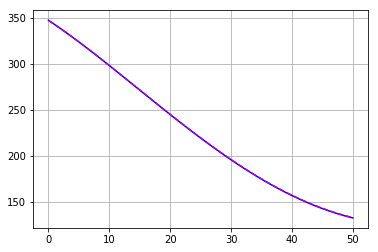

In [15]:
i = 950
plt.figure();
plt.plot(T_hist[:,i],'b-')
plt.plot(X_hist[:,i],'m--')
plt.grid()
plt.show()

In [16]:
N

1000

In [17]:
iter=0; 
nframes = 100 # numero di fotogrammi 
intervaln = 500 # tempo (in millisecondi) di ritardo tra un fotogramma e il successivo
fig = plt.figure() 
ax = plt.axes(xlim=(0, T_hist.shape[0]), ylim=(-10.0,10.0)) 
linev, = ax.plot([], [], 'g--', lw=2) # Viene definito un oggetto lineare (linea) generico
lineo, = ax.plot([], [], 'm-', lw=2) # Viene definito un oggetto lineare (linea) generico

vx = np.arange(0,T_hist.shape[0])

def init(): 
  linev.set_data([], [])
  lineo.set_data([], [])
  return linev,lineo,

def animate(i): 
  global iter
  linev.set_data(vx,T_hist[:,i])
  lineo.set_data(vx,X_hist[:,i])
  iter = iter+1;
  #dx = np.amax([0.1, abs(yp)])
  plt.draw()
  return linev,lineo,

ymax = 150
ymin = -1
xmax = T_hist.shape[0]
xmin = 0
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nframes, interval=intervaln, blit=False) 
ax.axis((xmin, xmax, ymin, ymax))
plt.close(anim._fig)

if False:
    rcParams['animation.writer'] = 'ffmpeg'
    # Call function to display the animation
    HTML(anim.to_html5_video())
else:
    anim.save('filename.gif', writer='pillow')
#endif

<Figure size 432x288 with 0 Axes>

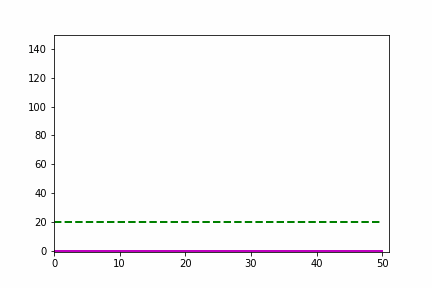

In [18]:
with open('filename.gif','rb') as file:
    display(Image(file.read()), format='png')